In [43]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import torch
from cvxpylayers.torch import CvxpyLayer
torch.set_default_dtype(torch.double)
np.set_printoptions(precision=3, suppress=True)
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from numpy.random import default_rng
from scipy.spatial import distance_matrix

rng = default_rng()

In [44]:
torch.manual_seed(0)
np.random.seed(0)

m = 30
p = 0.008
std = 0.7

outlier = 5
means = np.array([[2, 2], [-2, -2], [5, -1]])
(K, n) = means.shape

probs = rng.random(K)
probs = probs/probs.sum()
probs = [0.33, 0.33, 0.34]
print(probs)

groups = rng.choice(np.arange(0, K), size = m, p=probs)

means = np.array([[2, 2], [-2, -2], [5, -1]])
K = len(means)
X_train = []
X_test = []
for pt in range(len(groups)):
    dist_type = groups[pt]
    X_train.append(means[dist_type] + std*rng.normal(size = n))
    X_test.append(means[dist_type] + std*rng.normal(size = n))

X_train = np.array(X_train)
X_test = np.array(X_test)

[0.33, 0.33, 0.34]


In [45]:
def base_model(m,n):
    a = cp.Variable((m,n))
    
    ws = cp.Parameter(int(m*(m-1)/2), nonneg = True)
    X_train = cp.Parameter((m,n))

    error = cp.norm(a - X_train, "fro")
    regularization =  0

    for k in range(int(m*(m-1)/2)):
        #print(index)
        (i,j) = indices[k]
        regularization += ws[k]*cp.norm(a[i,:] - a[j,:], 1)

    obj = cp.Minimize(error + regularization)
    prob = cp.Problem(obj)
    
    return CvxpyLayer(prob, [ws, X_train], [a])

opt_layer = base_model(m,n)

In [46]:
gamma = 1
m = X_train.shape[0]
assignment = np.zeros(int(m*(m-1)/2))
k = 0
indices = {}
for i in range(m):
    for j in range(m):
        if i < j:
            indices[k] = (i,j)
            norm = np.linalg.norm(X_train[i,:] - X_train[j,:], ord = 1)
            assignment[k] = norm 
            k = k+1
ws_tch, X_train_tch, X_test_tch = map(torch.from_numpy, [np.exp((-1)*gamma*assignment), X_train, X_test])
X_train_tch.requires_grad_(True);
ws_tch.requires_grad_(True);

In [47]:
a_tch,  = opt_layer(ws_tch, X_train_tch)

In [52]:
def loss_fn(X, a_tch):
    loss = torch.norm(X - a_tch,p='fro')
    return loss

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, fit_lr, loss_fn):
        super(Net, self).__init__()
        self.pdist = nn.functional.pdist
        self.Relu = nn.ReLU()
        self.gamma = nn.Parameter(torch.tensor([1.0]))
        self.lamb_tch = nn.Parameter(torch.tensor([1.0]))
        
        self.perf_loss = loss_fn

#         self.lamb_tch.requires_grad_(True);
#         self.ws_tch.requires_grad_(True);
            
        self.cvx_lr = fit_lr
        
    # X represents our data
    def forward(self, X):
        #calculate pairwise distances
        norms = self.pdist(X)
        gamma_pos = self.Relu(self.gamma)
        lamb_tch_pos = self.Relu(self.lamb_tch)
        ws_tch = torch.mul(lamb_tch_pos, torch.exp(torch.mul(norms, (-1.0)*gamma_pos)))
        # Use the rectified-linear activation function over x
        a_tch = self.cvx_lr(ws_tch, X)
        
        return a_tch[0]
    
    #-----------------------------------------------------------------------------------------------
    # net_train: Train the e2e neural net
    #-----------------------------------------------------------------------------------------------
    def net_train(self, train_set, val_set=None, epochs=None, lr=None):
        """Neural net training module
        
        Inputs
        train_set: SlidingWindow object containing feaatures x, realizations y and performance
        realizations y_perf
        val_set: SlidingWindow object containing feaatures x, realizations y and performance
        realizations y_perf
        epochs: Number of training epochs
        lr: learning rate
        Output
        Trained model
        (Optional) val_loss: Validation loss
        """

        # Assign number of epochs and learning rate
        if epochs is None:
            epochs = self.epochs
        if lr is None:
            lr = self.lr
        
        # Define the optimizer and its parameters
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)

        # Number of elements in training set
        n_train = len(train_set)

        # Train the neural network
        for epoch in range(epochs):
                
            # TRAINING: forward + backward pass
            train_loss = 0
            optimizer.zero_grad() 
            for t, (X_prev, X_next) in enumerate(train_set):

                # Forward pass: predict and optimize
                a_hat = self(X_prev)

                # Loss function
    
                loss = (1/n_train) * self.perf_loss(X_next, a_hat)
                print(loss)
                # Backward pass: backpropagation
                loss.backward()

                # Accumulate loss of the fully trained model
                train_loss += loss.item()
        
            # Update parameters
            optimizer.step()

#             # Ensure that gamma, delta > 0 after taking a descent step
#             for name, param in self.named_parameters():
#                 if name=='gamma':
#                     param.data.clamp_(0.0001)
#                 if name=='delta':
#                     param.data.clamp_(0.0001)

        # Compute and return the validation loss of the model
        if val_set is not None:

            # Number of elements in validation set
            n_val = len(val_set)

            val_loss = 0
            with torch.no_grad():
                for t, (X_prev, X_next) in enumerate(val_set):

                    # Predict and optimize
                    a_hat = self(X_prev)
                
                    # Loss function
                 
                    loss = (1/n_val) * self.perf_loss(z_val, y_perf.squeeze())
                  
                    # Accumulate loss
                    val_loss += loss.item()

            return train_loss, val_loss


In [53]:
net = Net(opt_layer, loss_fn)

In [54]:
net

Net(
  (Relu): ReLU()
  (cvx_lr): CvxpyLayer()
)

In [64]:
net.net_train([(X_train_tch, X_test_tch)] , val_set=None, epochs=40, lr=1e-2)

C:\Users\David\anaconda3\envs\cvxpy\lib\site-packages\diffcp\cone_program.py:296: UserWarning: Solved/Inaccurate.
  warnings.warn("Solved/Inaccurate.")


tensor(7.2227, grad_fn=<MulBackward0>)
tensor(6.9704, grad_fn=<MulBackward0>)
tensor(6.7695, grad_fn=<MulBackward0>)
tensor(6.6072, grad_fn=<MulBackward0>)
tensor(6.4739, grad_fn=<MulBackward0>)
tensor(6.3637, grad_fn=<MulBackward0>)
tensor(6.2714, grad_fn=<MulBackward0>)
tensor(6.1935, grad_fn=<MulBackward0>)
tensor(6.1272, grad_fn=<MulBackward0>)
tensor(6.0706, grad_fn=<MulBackward0>)
tensor(6.0218, grad_fn=<MulBackward0>)
tensor(5.9792, grad_fn=<MulBackward0>)
tensor(5.9421, grad_fn=<MulBackward0>)
tensor(5.9096, grad_fn=<MulBackward0>)
tensor(5.8810, grad_fn=<MulBackward0>)
tensor(5.8558, grad_fn=<MulBackward0>)
tensor(5.8333, grad_fn=<MulBackward0>)
tensor(5.8133, grad_fn=<MulBackward0>)
tensor(5.7954, grad_fn=<MulBackward0>)
tensor(5.7793, grad_fn=<MulBackward0>)
tensor(5.7648, grad_fn=<MulBackward0>)
tensor(5.7517, grad_fn=<MulBackward0>)
tensor(5.7399, grad_fn=<MulBackward0>)
tensor(5.7291, grad_fn=<MulBackward0>)
tensor(5.7193, grad_fn=<MulBackward0>)
tensor(5.7103, grad_fn=<M

C:\Users\David\anaconda3\envs\cvxpy\lib\site-packages\diffcp\cone_program.py:296: UserWarning: Solved/Inaccurate.
  warnings.warn("Solved/Inaccurate.")


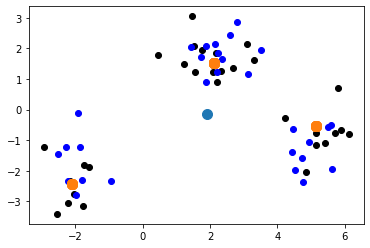

In [65]:
# for i in range(m):
#     points = [a_values[k][i] for k in range(len(lamb_vals))]
#     x = [point[0] for point in points]
#     y = [point[1] for point in points]
#     plt.plot(x,y, color =  'grey')
plt.plot(X_train[:,0], X_train[:,1], 'o', color = 'black')
plt.plot(X_train[:,0].mean(), X_train[:,1].mean(), 'o', markersize=10)
plt.plot(X_test[:,0], X_test[:,1], 'o', color = 'blue')
pred = net(X_train_tch)
plt.plot(pred[:,0].detach().numpy(), pred[:,1].detach().numpy(), 'o', markersize=10)